# Machine Learning
## Miniproject 2
Dragi Kamov and Aadil Kumar

## Used libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from sklearn.decomposition import PCA

## Loading data

In [4]:
vectors = np.loadtxt('data/mfeat-pix.txt')

## Feature extraction 
Feature extraction is a dimensionality reduction process used in machine learning to derive values (features) that are important from a dataset and thus reduce it to more manageable groups for processing.

## Types of features 
There are three main types of features and those are:
- K-means based features are features that group a collection of data points into related clusters $ C_1, ..., C_K $, each of them being represented by a codebook vector $ c_i $.
- Hand-made features are referring to properties derived from human insight on information that is in the images.
- Principal Component Analysis (PCA) is a feature that reduces the dimensionality of a data set consisting of many variables correlated with each other, while retaining the variation present in the dataset, up to the maximum extent.

In this assignment we will use PCA for feature extraction.
### The steps in PCA algorithm follows:

- centering the data: mapping each vector $x_i \to \bar{x_i}$, where $\bar{x_i} = x_i - \bar{x}$
- calculating the $\mu_1, \mu_2, ... \mu_m$, where $m$ is the number of principle components
   $\mu_i$ is calculated via $SVD$ algorithm.
   
   1. We calculate the correlation matrix $R$.
   2. Calculate the SVD via $$[U, \Sigma, V^*] = SVD(R)$$, where
   $$ R = U \Sigma V^* $$
   3. Extract the principle components $\mu_1, \mu_2, ... \mu_m$, where $ m < n$, by taking the first $m$ columns of $U$. 
- Compression: we take each $\mu_1, \mu_2, \mu_3 ... $ and dot product the already centered $\bar{x_i}$ to obtain a vector $v \in \mathbb{R}^m$
 \begin{align*}
 v = \begin{bmatrix}
 \mu_1 \cdot \bar{x_i} \\
  \mu_2 \cdot \bar{x_i} \\
   \mu_3 \cdot \bar{x_i} \\
    \mu_4 \cdot \bar{x_i} \\
    ... \\
    \mu_m \cdot \bar{x_i}
 \end{bmatrix}
 \end{align*}
- Decompression: we simply calculate
 $$ recovered = \sum_{i = 1}^{m} v_i \cdot \mu_i $$
Additionally, we split the training data into training set $X$ and test set $Xtest$, and build its associated label one-hot encoding vector matrix $Y$ and $Ytest$ 

## Adding bias

We then create a fuction to add the bias term to the features. Linear regression will create a model based on offine function, which contains a bias term. Without it, we can only approximate the data using linear function, and it would lead to a very bad model.

In [5]:
def add_bias(X):
    N, D = X.shape
    Y = np.ones((N, D + 1))
    Y[:,:-1] = X
    return Y

def square_norm(x):
    return np.sum(np.power(x, 2))

## Use One-hot encoding to generate class vector
Since the dataset doesn't contain any kind of label, we need to generate a class vector for each label $\{0, 1, 2, ... 10\}$ as $v \in \mathbb{R}^{10}$. The following function will execute such a strategy.

In [6]:
def onehot_encode(digit):
    rst = np.zeros(10)
    rst[digit] = 1
    return rst

# Linear Regression Implementation
For a given dataset $data$ and a fixed number of feature $k$,
our algorithm of linear regression proceed as the following:
1. Performing a PCA algorithm to reduce the dimensions of $data$ from $\mathbb{R}^{240}$ to $\mathbb{R}^{k}$. Thus, we can view PCA algorithms as a function $PCA: \mathbb{R}^{240} \to \mathbb{R}^{k}$
2. Split the entire dataset after dimension reduction into training set features $X \in \mathbb{R}^{1000 \times k}$ and test set features $X_{test} \in \mathbb{R}^{1000 \times k}$
3. Associate $X$ and $X_{test}$ with bias term, thus we have $X, X_{test} \in \mathbb{R}^{1000 \times (K + 1)}$ 
4. Build the correct class vector for training set as $Y \in \mathbb{R}^{(k + 1) \times 10}$ and test set as $Y_{test} \in \mathbb{R}^{(k + 1) \times 10}$. After such operation, we obtained the complete training set as $(X, Y)$ and the test set as $(X_{test}, Y_{test})$
5. Using the training set, compute the optimal weight matrix as
$$ {W_{opt}}^\top = (\frac{1}{N} \cdot X^\top \cdot X + \alpha^2 \cdot I_{nxn})^{-1} \cdot \frac{1}{N} \cdot X^\top \cdot Y $$
we can rewrite as
$$ W_{opt} = ((\frac{1}{N} \cdot X^\top \cdot X + \alpha^2 \cdot I_{nxn})^{-1} \cdot \frac{1}{N} \cdot X^\top \cdot Y)^\top $$
6. Calculate the error term.
First, we make the prediction:
$$ Y_{pred} = (W_{opt} \cdot X^\top)^\top $$
$$ Y_{test}pred = (W_{opt} \cdot {X_{test}}^\top)^\top $$
Using the prediction, we calculate the corresponding error
$$ MSE_{train} = \frac{\|Y - Ypred\|^2}{1000} $$
$$ MSE_{test} = \frac{\|Ytest - Y_{test}pred\|^2}{1000} $$
$$ MISS_{train} = \frac{\sum_{i = 1}^{1000} \min(1, \|\arg\max(Y_i) - \arg\max(Ypred_i)\|)}{1000} $$
$$ MISS_{test} = \frac{\sum_{i = 1}^{1000} \min(1, \|\arg\max({Y_{test}}_i) - \arg\max(Y_{test}pred_i)\|)}{1000} $$

In [126]:
def linear_regression(data, k):
    # Performing PCA
    pca = PCA(n_components=k)
    data_pca = pca.fit_transform(data)
    
    # Splitting the training set
    X = np.ones((1000, k))
    Xtest = np.ones((1000, k))
    for i in range(10):
        X[i*100:i*100 + 100][:] = data_pca[i*200:i*200 + 100][:]
        Xtest[i*100:i*100 + 100][:] = data_pca[i*200 + 100:i*200 + 200][:]
    
    # Adding the bias term
    X = add_bias(X)
    Xtest = add_bias(Xtest)
    
    # Building the class
    Y = np.zeros((1000, 10))
    Ytest = np.zeros((1000, 10))
    
    for i in range(1000):
        digit = i // 100
        Y[i] = onehot_encode(digit).T # Assigning the one-hot encoding
        Ytest[i] = onehot_encode(digit).T # Also here

    left = la.inv((1/1000) * np.matmul(X.T, X) + (0 * np.eye(k+1))) * (1/1000)
    right = np.matmul(X.T, Y)

    # Calculating the optimal weight
    Wopt = (np.dot(left,right)).T
    
    # Calculating the training error term
    # We first need to make a prediction
    Ypred = np.matmul(Wopt, X.T).T
    Ytestpred = np.matmul(Wopt, Xtest.T).T
    
    # Then we need to calculate the error
    mse_train = square_norm(Ypred - Y) / 1000.0
    num_miss_train = 0

    for i in range(1000):
        if np.argmax(Ypred[i]) != np.argmax(Y[i]):
            num_miss_train = num_miss_train + 1
    miss_train = num_miss_train / 1000.0
    
    mse_test = square_norm(Ytestpred - Ytest) / 1000.0
    num_miss_test = 0
    
    for i in range(1000):
        if np.argmax(Ytestpred[i]) != np.argmax(Ytest[i]):
            num_miss_test = num_miss_test + 1
            
    miss_test = num_miss_test / 1000.0
    
    return Wopt, mse_train, miss_train, mse_test, miss_test

In [127]:
_, mse_train, miss_train, mse_test, miss_test = linear_regression(vectors, 40)
print('mse_train = {}, miss_train = {}, mse_test = {}, miss_test = {}'.format(mse_train, miss_train, mse_test, miss_test))

mse_train = 0.30386872582612023, miss_train = 0.053, mse_test = 0.32149272403178397, miss_test = 0.056


# Plotting the k and the errors
We variate k and check to see how the error changes
1. First, plot the data using linear scaling

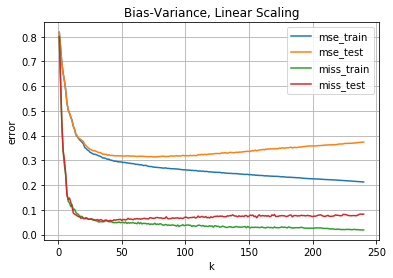

In [128]:
# Plotting the k and the errors
ks = []
mse_trains = []
miss_trains = []
mse_tests = []
miss_tests = []
for k in range(1, 241):
    _, mse_train, miss_train, mse_test, miss_test = linear_regression(vectors, k)
    ks.append(k)
    mse_trains.append(mse_train)
    miss_trains.append(miss_train)
    mse_tests.append(mse_test)
    miss_tests.append(miss_test)

plt.xlabel('k')
plt.ylabel('error')
plt.title('Bias-Variance, Linear Scaling')
plt.grid(True)
p1, = plt.plot(ks, mse_trains, label = 'mse_train')
p2, = plt.plot(ks, mse_tests, label = 'mse_test')
p3, = plt.plot(ks, miss_trains, label = 'miss_train')
p4, = plt.plot(ks, miss_tests, label = 'miss_test')
plt.legend(handles=[p1, p2, p3, p4])
plt.show()

2. Then, use log-log scaling of the data

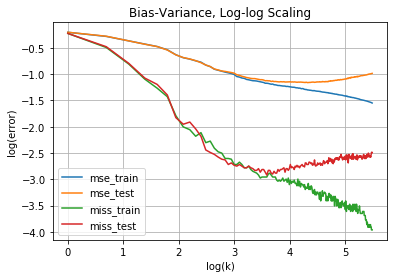

In [129]:
# Log plot
plt.xlabel('log(k)')
plt.ylabel('log(error)')
plt.title('Bias-Variance, Log-log Scaling')
plt.grid(True)
p1, = plt.plot(np.log(ks), np.log(mse_trains), label = 'mse_train')
p2, = plt.plot(np.log(ks), np.log(mse_tests), label = 'mse_test')
p3, = plt.plot(np.log(ks), np.log(miss_trains), label = 'miss_train')
p4, = plt.plot(np.log(ks), np.log(miss_tests), label = 'miss_test')
plt.legend(handles=[p1, p2, p3, p4])
plt.show()

In [32]:
_, mse_train, miss_train, mse_test, miss_test = linear_regression(vectors, 1)
print("mse_train =", mse_train, ", miss_train =", miss_train, ", mse_test =", mse_test, ", miss_test =",miss_test)

mse_train = 0.0016303054383496826 , miss_train = 0.0 , mse_test = 0.0016888622955584958 , miss_test = 0.0


In [33]:
_, mse_train, miss_train, mse_test, miss_test = linear_regression(vectors, 240)
print("mse_train =", mse_train, ", miss_train =", miss_train, ", mse_test =", mse_test, ", miss_test =",miss_test)

mse_train = 0.23832487277908213 , miss_train = 0.036 , mse_test = 0.24009979766389591 , miss_test = 0.161
